#Importar librerias

In [ ]:
# Instalación de librerias
import pandas as pd
import numpy as np
!pip install ftfy
!pip install plot_confusion_matrix

import ftfy
import sys
!{sys.executable} -m pip install pandas-profiling
from nltk.stem import PorterStemmer

import re, string, unicodedata
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix

# Para crear el arbol de decisión
from sklearn.tree import DecisionTreeClassifier
# Para usar KNN como clasificador
from sklearn.neighbors import KNeighborsClassifier
# Para evaluar el modelo
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold
#Librerías para la visualización
import matplotlib.pyplot as plt
# Seaborn
import seaborn as sns
from sklearn import tree

In [ ]:
# librería Natural Language Toolkit, usada para trabajar con textos
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
 # Descarga todas las palabras vacias, es decir, aquellas que no aportan nada al significado del texto
nltk.download('stopwords')

#Descarga de paquete WordNetLemmatizer, este es usado para encontrar el lema de cada palabra
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#Carga de datos

In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

Modificación a errores de gramatica como tildes

In [ ]:
# Archivo Excel
excel_path = '/content/ODScat_345.xlsx'
datos = pd.read_excel(excel_path, engine='openpyxl')

# Guardar Archivo CSV temporal
csv_temp_path = '/content/ODScat_345_temp.csv'
datos.to_csv(csv_temp_path, index=False)


# Aplicar ftfy para corregir la codificación
datos['Textos_espanol'] = datos['Textos_espanol'].apply(ftfy.fix_text)

# Revisar los datos corregidos
print(datos.head())

# Guardar el DataFrame corregido en un archivo CSV
csv_path = '/content/ODScat_345_corrected.csv'
datos.to_csv(csv_path, index=False, encoding='utf-8')

                                      Textos_espanol  sdg
0  Por ejemplo, el número de consultas externas d...    3
1  En 2007, el gobierno central financió directam...    3
2  Claramente, hay muchos otros factores en juego...    3
3  Por ejemplo, el estado australiano de Victoria...    3
4  El consumo anual de alcohol se estima en 15,7 ...    3


In [ ]:
datos.shape

(4049, 2)

In [ ]:
datos.sample(10)

,Textos_espanol,sdg
2258,En las sociedades en conflicto se impone una e...,5
1976,"En 2008, la OCDE/IMHE lanzó una segunda serie ...",4
990,Los hombres que han recibido educación superio...,3
1296,El problema es peor entre los niños indígenas ...,4
139,El Ministerio de Salud inició el desarrollo de...,3
3175,Los sistemas de pago vinculados al rendimiento...,3
964,Dos tercios del gasto en salud se financian co...,3
1671,Las restricciones financieras nacionales han r...,4
331,Se han encontrado resultados similares en estu...,3
1175,"La elección abierta de escuelas, si no se mane...",4


# Entendimiento de los datos

In [ ]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4049 entries, 0 to 4048
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Textos_espanol  4049 non-null   object
 1   sdg             4049 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 63.4+ KB


In [ ]:
datos.describe()

,sdg
count,4049.000000
mean,4.051124
std,0.814338
min,3.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


##Estadisticas discriptivas

In [ ]:
from scipy import stats as st

textos = datos.copy()
textos['Conteo'] = [len(x) for x in textos['Textos_espanol']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Textos_espanol']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Textos_espanol']]

textos

,Textos_espanol,sdg,Conteo,Max,Min
0,"Por ejemplo, el número de consultas externas d...",3,935,18,1
1,"En 2007, el gobierno central financió directam...",3,476,14,1
2,"Claramente, hay muchos otros factores en juego...",3,1207,15,1
3,"Por ejemplo, el estado australiano de Victoria...",3,1090,17,1
4,"El consumo anual de alcohol se estima en 15,7 ...",3,895,13,1
...,...,...,...,...,...
4044,"Para ello, identificará las cuestiones de géne...",5,822,16,1
4045,La participación de las mujeres en roles de li...,5,514,16,1
4046,"Según el WEF, según las tendencias de 2016, po...",5,445,17,1
4047,"Sirve como recurso y foro para las agencias, c...",5,1013,15,1


#Preparación de datos


##Limpieza de datos

In [ ]:
#Duplicar datos
datos1 = datos.copy()
#Revisar duplicados
duplicados = datos1.duplicated().sum()
print(f"Número de filas duplicadas: {duplicados}")

for column in datos1.columns:
    valoresUnicos = datos1[column].nunique()
    print(f"Columna '{column}' tiene {valoresUnicos} valores únicos.")


Número de filas duplicadas: 0
Columna 'Textos_espanol' tiene 4049 valores únicos.
Columna 'sdg' tiene 3 valores únicos.


In [ ]:
import re
from nltk.tokenize import word_tokenize

##articulos = set(['la', 'el', 'los', 'las', 'un', 'una', 'unos', 'unas','y','que','por','en','que','del','como','para','de','con','se','lo','e','su','ejemplo','embargo','más'])

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    return [word.lower() for word in words]

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words

#def remove_articles(words):
 #   """Remove articles from the list of tokenized words"""
  #  return [word for word in words if word not in articulos]
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    stop_words = set(stopwords.words('spanish'))
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return filtered_words

def preprocessing(words):
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words




##Tokenización

In [ ]:
datos1['words'] = datos1['Textos_espanol'].apply(word_tokenize)
datos1.head()


,Textos_espanol,sdg,words
0,"Por ejemplo, el número de consultas externas d...",3,"[Por, ejemplo, ,, el, número, de, consultas, e..."
1,"En 2007, el gobierno central financió directam...",3,"[En, 2007, ,, el, gobierno, central, financió,..."
2,"Claramente, hay muchos otros factores en juego...",3,"[Claramente, ,, hay, muchos, otros, factores, ..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[Por, ejemplo, ,, el, estado, australiano, de,..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[El, consumo, anual, de, alcohol, se, estima, ..."


In [ ]:
datos1['words1'] = datos1['words'].apply(preprocessing)

print(datos1.head())

                                      Textos_espanol  sdg  \
0  Por ejemplo, el número de consultas externas d...    3   
1  En 2007, el gobierno central financió directam...    3   
2  Claramente, hay muchos otros factores en juego...    3   
3  Por ejemplo, el estado australiano de Victoria...    3   
4  El consumo anual de alcohol se estima en 15,7 ...    3   

                                               words  \
0  [Por, ejemplo, ,, el, número, de, consultas, e...   
1  [En, 2007, ,, el, gobierno, central, financió,...   
2  [Claramente, ,, hay, muchos, otros, factores, ...   
3  [Por, ejemplo, ,, el, estado, australiano, de,...   
4  [El, consumo, anual, de, alcohol, se, estima, ...   

                                              words1  
0  [ejemplo, número, consultas, externas, especia...  
1  [2007, gobierno, central, financió, directamen...  
2  [claramente, factores, juego, particular, vari...  
3  [ejemplo, australiano, victoria, creó, agencia...  
4  [consumo, anual, a

In [ ]:
y_data = datos1['sdg']
class_distribution = y_data.value_counts()
print("Distribución de clases:")
print(class_distribution)

Distribución de clases:
sdg
5    1451
4    1354
3    1244
Name: count, dtype: int64


##Normalización

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, pos=wordnet.VERB) for word in words]
    return lemmatized_words

datos1['words1'] = datos1['words1'].apply(lemmatize_verbs)
datos1.head()

,Textos_espanol,sdg,words,words1
0,"Por ejemplo, el número de consultas externas d...",3,"[Por, ejemplo, ,, el, número, de, consultas, e...","[ejemplo, número, consultas, externas, especia..."
1,"En 2007, el gobierno central financió directam...",3,"[En, 2007, ,, el, gobierno, central, financió,...","[2007, gobierno, central, financió, directamen..."
2,"Claramente, hay muchos otros factores en juego...",3,"[Claramente, ,, hay, muchos, otros, factores, ...","[claramente, factor, juego, particular, varied..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[Por, ejemplo, ,, el, estado, australiano, de,...","[ejemplo, australiano, victoria, creó, agencia..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[El, consumo, anual, de, alcohol, se, estima, ...","[consumo, anual, alcohol, estima, 157, litros,..."


##Selección de campos

In [ ]:
datos1['words1'] = datos1['words1'].apply(lambda x: ' '.join(map(str, x)))
datos1

,Textos_espanol,sdg,words,words1
0,"Por ejemplo, el número de consultas externas d...",3,"[Por, ejemplo, ,, el, número, de, consultas, e...",ejemplo número consultas externas especialista...
1,"En 2007, el gobierno central financió directam...",3,"[En, 2007, ,, el, gobierno, central, financió,...",2007 gobierno central financió directamente so...
2,"Claramente, hay muchos otros factores en juego...",3,"[Claramente, ,, hay, muchos, otros, factores, ...",claramente factor juego particular variedad ba...
3,"Por ejemplo, el estado australiano de Victoria...",3,"[Por, ejemplo, ,, el, estado, australiano, de,...",ejemplo australiano victoria creó agencia prom...
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[El, consumo, anual, de, alcohol, se, estima, ...",consumo anual alcohol estima 157 litros año ho...
...,...,...,...,...
4044,"Para ello, identificará las cuestiones de géne...",5,"[Para, ello, ,, identificará, las, cuestiones,...",ello identificará cuestiones género destacadas...
4045,La participación de las mujeres en roles de li...,5,"[La, participación, de, las, mujeres, en, role...",participación mujeres roles liderazgo dentro l...
4046,"Según el WEF, según las tendencias de 2016, po...",5,"[Según, el, WEF, ,, según, las, tendencias, de...",según wef según tendencias 2016 podría cerrars...
4047,"Sirve como recurso y foro para las agencias, c...",5,"[Sirve, como, recurso, y, foro, para, las, age...",sirve recurso foro agencias objetivo lograr en...


In [ ]:
X_data, y_data = datos1['words1'],datos1['sdg']
y_data = (y_data == 'spam').astype(int)
y_data

,sdg
0,0
1,0
2,0
3,0
4,0
...,...
4044,0
4045,0
4046,0
4047,0


In [ ]:
count = CountVectorizer()
X_count = count.fit_transform(datos1['words1'])
print(X_count.shape)
print(X_count.toarray()[0])

(4049, 20454)
[0 0 0 ... 0 0 0]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vectorizer = TfidfVectorizer()
X_tf_idf = tf_idf_vectorizer.fit_transform(datos1['words1'])
print(X_tf_idf.shape)  # Dimensiones de la matriz (número de documentos, número de términos)

print(X_tf_idf.toarray()[0])  # Representación TF-IDF del primer documento

(4049, 20454)
[0. 0. 0. ... 0. 0. 0.]


In [ ]:
print(datos1['words1'].head())

0    ejemplo número consultas externas especialista...
1    2007 gobierno central financió directamente so...
2    claramente factor juego particular variedad ba...
3    ejemplo australiano victoria creó agencia prom...
4    consumo anual alcohol estima 157 litros año ho...
Name: words1, dtype: object


In [ ]:
print(datos1['sdg'].unique())
print(datos1['sdg'].value_counts())

[3 4 5]
sdg
5    1451
4    1354
3    1244
Name: count, dtype: int64


In [ ]:
ods_values = ['3', '4', '5']
for ods in ods_values:
    filtered_data = datos1[datos1['sdg'] == ods]
    print(f"Datos para ODS {ods}:")
    print(filtered_data.head())
    print(f"Número de registros para ODS {ods}: {filtered_data.shape[0]}")

Datos para ODS 3:
Empty DataFrame
Columns: [Textos_espanol, sdg, words, words1]
Index: []
Número de registros para ODS 3: 0
Datos para ODS 4:
Empty DataFrame
Columns: [Textos_espanol, sdg, words, words1]
Index: []
Número de registros para ODS 4: 0
Datos para ODS 5:
Empty DataFrame
Columns: [Textos_espanol, sdg, words, words1]
Index: []
Número de registros para ODS 5: 0


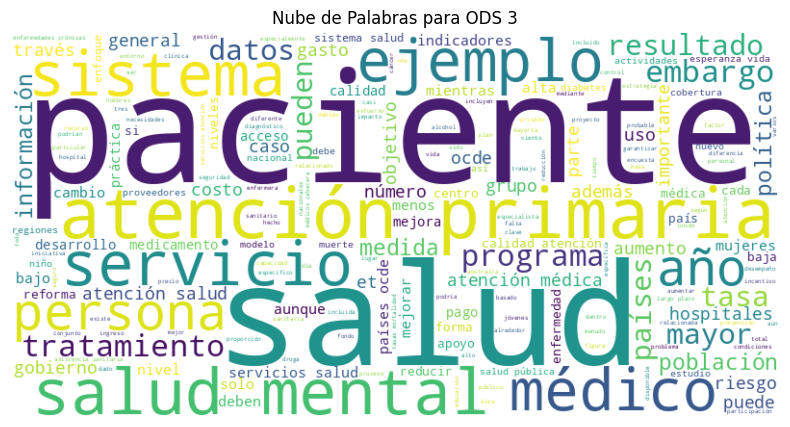

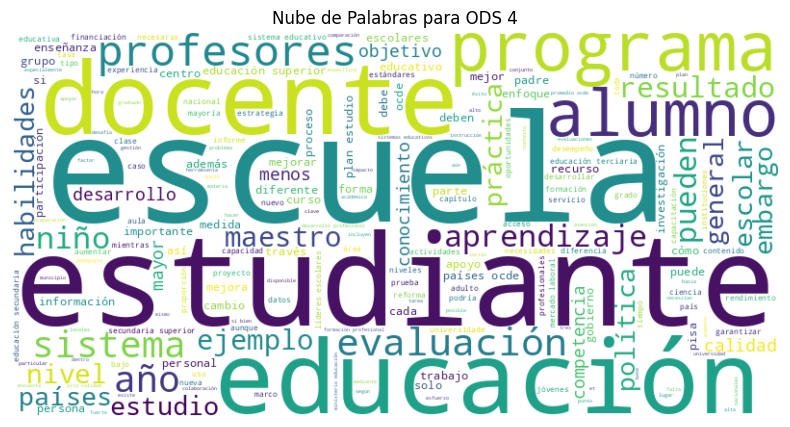

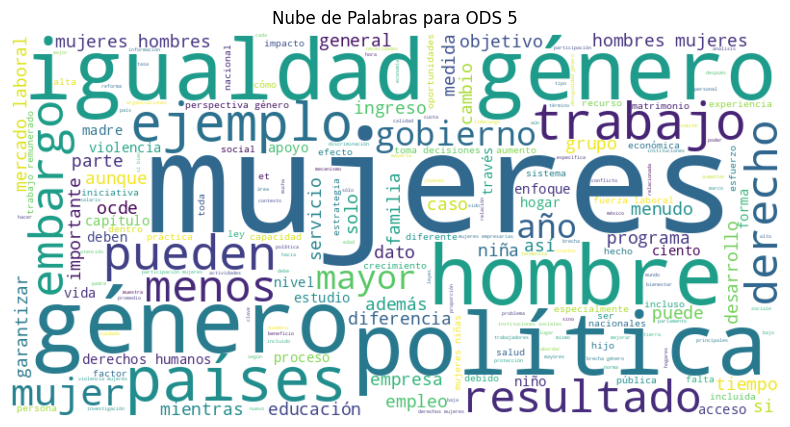

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for ods in [3, 4,5]:
    text_for_ods = ' '.join(datos1[datos1['sdg'] == ods]['words1'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_for_ods)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Nube de Palabras para ODS {ods}')
    plt.axis('off')
    plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def print_most_frequent_words(texts, n=10):
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(texts)
    words = vectorizer.get_feature_names_out()
    sums = X.sum(axis=0)
    word_freq = [(word, sums[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(word_freq, columns=['Word', 'Frequency'])
    print(df.head(n))

for ods in [3, 4,5]:
    texts_for_ods = datos1[datos1['sdg'] == ods]['words1']
    print(f"Palabras más frecuentes para ODS {ods}:")
    print_most_frequent_words(texts_for_ods, n=10)
    print("\n")

Palabras más frecuentes para ODS 3:
        Word  Frequency
0      salud       1487
1   atención       1170
2  servicios        626
3     países        475
4  pacientes        367
5     mental        338
6    calidad        333
7   primaria        330
8    sistema        324
9       años        315


Palabras más frecuentes para ODS 4:
          Word  Frequency
0    educación       1199
1  estudiantes        939
2     escuelas        716
3  aprendizaje        523
4         ocde        445
5   evaluación        433
6       países        417
7     docentes        409
8      escuela        401
9      alumnos        395


Palabras más frecuentes para ODS 5:
        Word  Frequency
0    mujeres       2849
1     género       1613
2    hombres        738
3   igualdad        560
4     países        514
5    trabajo        483
6   derechos        409
7  violencia        344
8  políticas        338
9     pueden        336




#Modelos

In [ ]:
labels = datos1['sdg'].tolist()
X = X_tf_idf  # La matriz TF-IDF obtenida anteriormente
y = labels    # Las etiquetas correspondientes (por ejemplo, ODS)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#KNN - VECINOS

##Predicciones y evaluación modelo

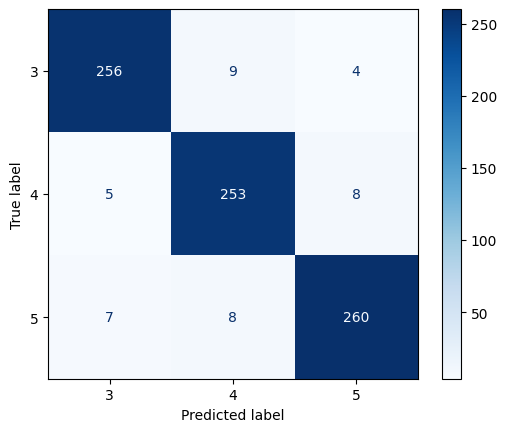

Exactitud: 0.95
Recall (macro): 0.9494184091523165
Precisión (macro): 0.9493810901917428
Puntuación F1 (macro): 0.9493715898902974


In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
# Hacer predicciones
y_pred_KNN = knn.predict(X_test)

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_KNN)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Imprimir las métricas de rendimiento
print('Exactitud: %.2f' % accuracy_score(y_test, y_pred_KNN))
print("Recall (macro): {}".format(recall_score(y_test, y_pred_KNN, average='macro')))
print("Precisión (macro): {}".format(precision_score(y_test, y_pred_KNN, average='macro')))
print("Puntuación F1 (macro): {}".format(f1_score(y_test, y_pred_KNN, average='macro')))


##Evaluación sobre conjunto de entrenamiento

In [ ]:
# Hacer predicciones sobre el conjunto de entrenamiento
y_pred_trainKNN = knn.predict(X_train)

# Métricas de rendimiento sobre el conjunto de entrenamiento
print('Exactitud: %.2f' % accuracy_score(y_train, y_pred_trainKNN))
print("Recall: {}".format(recall_score(y_train, y_pred_trainKNN, average='macro')))
print("Precisión: {}".format(precision_score(y_train, y_pred_trainKNN, average='macro')))
print("Puntuación F1: {}".format(f1_score(y_train, y_pred_trainKNN, average='macro')))

Exactitud: 0.97
Recall: 0.9652479132678713
Precisión: 0.9647568603837003
Puntuación F1: 0.9649645699903462


##Ajustes Hiperparametros

Mejores hiperparámetros encontrados:
{'n_neighbors': 13}


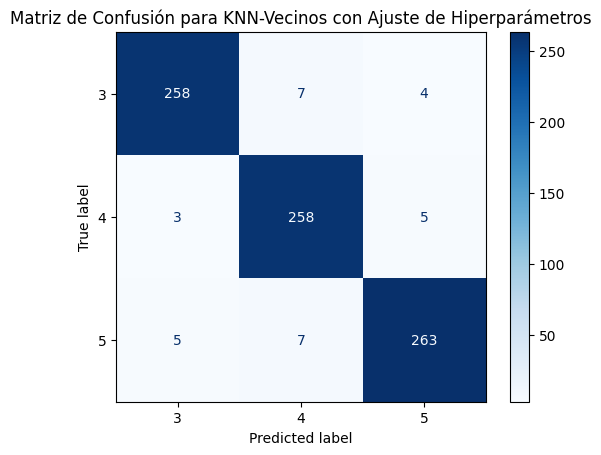

Exactitud: 0.96
Recall (macro): 0.9617987516950538
Precisión (macro): 0.9617886628335545
Puntuación F1 (macro): 0.9617341877123242


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13]}


knn = KNeighborsClassifier()


grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')


grid_search.fit(X_train, y_train)


print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)


best_knn = grid_search.best_estimator_

y_pred_KNN = best_knn.predict(X_test)

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_KNN)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión para KNN-Vecinos con Ajuste de Hiperparámetros')
plt.show()

print('Exactitud: %.2f' % accuracy_score(y_test, y_pred_KNN))
print("Recall (macro): {}".format(recall_score(y_test, y_pred_KNN, average='macro')))
print("Precisión (macro): {}".format(precision_score(y_test, y_pred_KNN, average='macro')))
print("Puntuación F1 (macro): {}".format(f1_score(y_test, y_pred_KNN, average='macro')))


#Arboles de Decisión

In [ ]:
# Seleccionar la variable objetivo
Y = datos1['sdg']

# Creación del objeto de árbol de decisión
arbol = DecisionTreeClassifier(criterion='entropy',random_state=0)

# Entrenamiento del modelo
arbol.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

##Predicciones y evaluación modelo

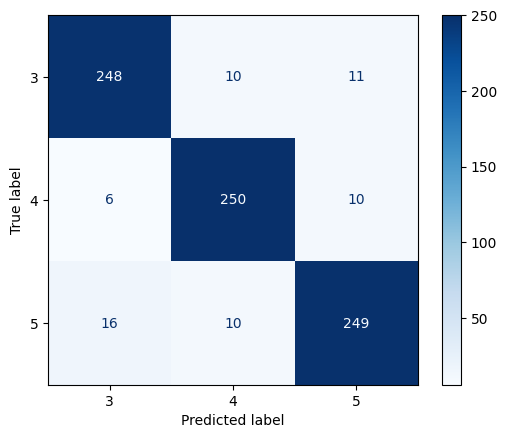

Exactitud: 0.92
Recall: 0.9224124183388515
Precisión: 0.9222222222222222
Puntuación F1: 0.922273307764593

Reporte de Clasificación:
              precision    recall  f1-score   support

           3       0.92      0.92      0.92       269
           4       0.93      0.94      0.93       266
           5       0.92      0.91      0.91       275

    accuracy                           0.92       810
   macro avg       0.92      0.92      0.92       810
weighted avg       0.92      0.92      0.92       810



In [ ]:
# Hacer predicciones sobre el conjunto de prueba
y_predA = arbol.predict(X_test)
# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_predA)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=arbol.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


# Métricas de rendimiento sobre el conjunto de prueba
print('Exactitud: %.2f' % accuracy_score(y_test, y_predA))
print("Recall: {}".format(recall_score(y_test, y_predA, average='macro')))
print("Precisión: {}".format(precision_score(y_test, y_predA, average='macro')))
print("Puntuación F1: {}".format(f1_score(y_test, y_predA, average='macro')))

# Mostrar reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_predA))

##Evaluación sobre conjunto de entrenamiento

In [ ]:
# Hacer predicciones sobre el conjunto de entrenamiento
y_pred_trainA = arbol.predict(X_train)

# Métricas de rendimiento sobre el conjunto de entrenamiento
print('Exactitud: %.2f' % accuracy_score(y_train, y_pred_trainA))
print("Recall: {}".format(recall_score(y_train, y_pred_trainA, average='macro')))
print("Precisión: {}".format(precision_score(y_train, y_pred_trainA, average='macro')))
print("Puntuación F1: {}".format(f1_score(y_train, y_pred_trainA, average='macro')))

Exactitud: 1.00
Recall: 1.0
Precisión: 1.0
Puntuación F1: 1.0


##Ajustes Hiperparametros

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejores hiperparámetros encontrados:
{'criterion': 'entropy', 'max_depth': 25}


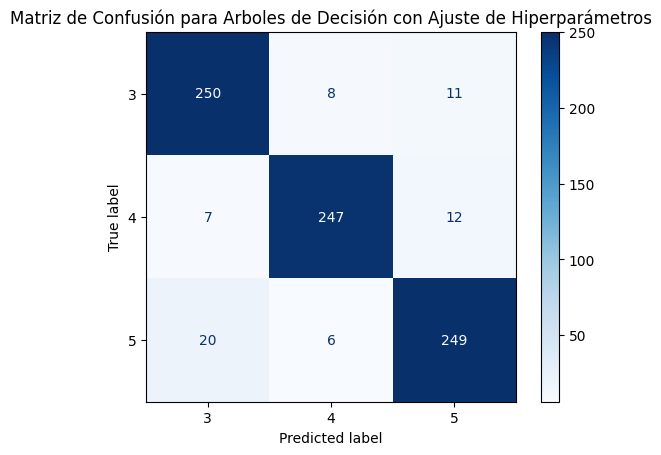

Exactitud: 0.92
Recall (macro): 0.9211313345885835
Precisión (macro): 0.9214428018465225
Puntuación F1 (macro): 0.9211842650818052


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Definir el modelo Árbol de Decisión
decision_tree = DecisionTreeClassifier(random_state=0)

# Definir los hiperparámetros para ajustar (corregido 'max_features')
param_grid = {
    'max_depth': [10, 15, 20, 25],  # Profundidad máxima del árbol
    'criterion': ['gini', 'entropy']  # Criterio de división
}

# Configurar GridSearchCV con 5-fold cross-validation
grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Entrenar el modelo utilizando GridSearchCV
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Utilizar el mejor modelo encontrado
best_tree = grid_search.best_estimator_

# Hacer predicciones en el conjunto de prueba
y_pred_tree = best_tree.predict(X_test)


# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_tree)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_tree.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión para Arboles de Decisión con Ajuste de Hiperparámetros')
plt.show()

# Evaluar el rendimiento del mejor modelo encontrado
print('Exactitud: %.2f' % accuracy_score(y_test, y_pred_tree))
print("Recall (macro): {}".format(recall_score(y_test, y_pred_tree, average='macro')))
print("Precisión (macro): {}".format(precision_score(y_test, y_pred_tree, average='macro')))
print("Puntuación F1 (macro): {}".format(f1_score(y_test, y_pred_tree, average='macro')))


#Random Forest

##Predicciones y evaluación modelo

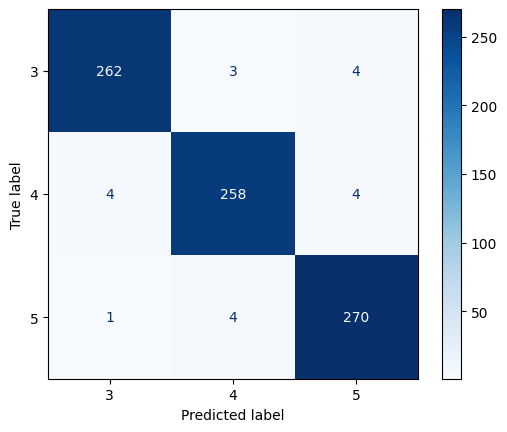

Exactitud: 0.98
Recall: 0.9752402296718478
Precisión: 0.9753604451609371
Puntuación F1: 0.9752850717652327

Reporte de Clasificación:
              precision    recall  f1-score   support

           3       0.98      0.97      0.98       269
           4       0.97      0.97      0.97       266
           5       0.97      0.98      0.98       275

    accuracy                           0.98       810
   macro avg       0.98      0.98      0.98       810
weighted avg       0.98      0.98      0.98       810



In [ ]:
# Crear el modelo Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=0)

# Entrenar el modelo
random_forest.fit(X_train, y_train)

# Hacer predicciones sobre el conjunto de prueba
y_predRandom = random_forest.predict(X_test)

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_predRandom)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_forest.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


# Métricas de rendimiento sobre el conjunto de prueba
print('Exactitud: %.2f' % accuracy_score(y_test, y_predRandom))
print("Recall: {}".format(recall_score(y_test, y_predRandom, average='macro')))
print("Precisión: {}".format(precision_score(y_test, y_predRandom, average='macro')))
print("Puntuación F1: {}".format(f1_score(y_test, y_predRandom, average='macro')))

# Mostrar reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_predRandom))

##Evaluación sobre conjunto de entrenamiento

In [ ]:
# Hacer predicciones sobre el conjunto de entrenamiento
y_pred_trainRandom = random_forest.predict(X_train)


# Métricas de rendimiento sobre el conjunto de entrenamiento
print('Exactitud: %.2f' % accuracy_score(y_train, y_pred_trainRandom))
print("Recall: {}".format(recall_score(y_train, y_pred_trainRandom, average='macro')))
print("Precisión: {}".format(precision_score(y_train, y_pred_trainRandom, average='macro')))
print("Puntuación F1: {}".format(f1_score(y_train, y_pred_trainRandom, average='macro')))

Exactitud: 1.00
Recall: 1.0
Precisión: 1.0
Puntuación F1: 1.0


##Ajustes Hiperparametros

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Mejores hiperparámetros encontrados:
{'max_depth': 50, 'n_estimators': 300}


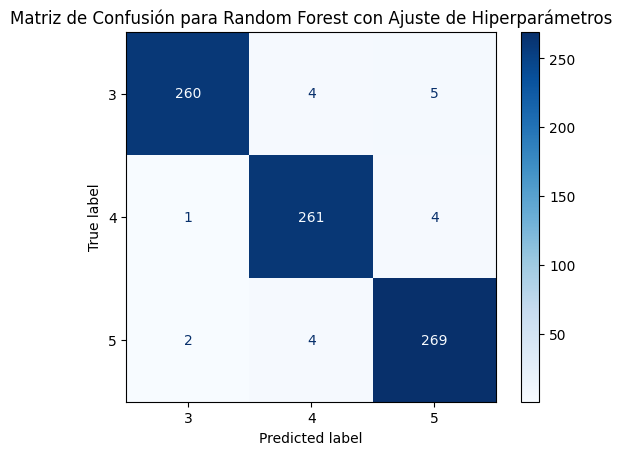

Exactitud: 0.98
Recall (macro): 0.9753091922099943
Precisión (macro): 0.9754930927408129
Puntuación F1 (macro): 0.9753399232139262


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Definir el modelo Random Forest
random_forest = RandomForestClassifier(random_state=0)

# Definir los hiperparámetros para ajustar
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árboles
    'max_depth': [10, 15, 20, 35, 50],  # Profundidad máxima del árbol

}

# Configurar GridSearchCV con 5-fold cross-validation
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Entrenar el modelo utilizando GridSearchCV
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Utilizar el mejor modelo encontrado
best_rf = grid_search.best_estimator_

# Hacer predicciones en el conjunto de prueba
y_pred_rf = best_rf.predict(X_test)


# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión para Random Forest con Ajuste de Hiperparámetros')
plt.show()

# Evaluar el rendimiento del mejor modelo encontrado
print('Exactitud: %.2f' % accuracy_score(y_test, y_pred_rf))
print("Recall (macro): {}".format(recall_score(y_test, y_pred_rf, average='macro')))
print("Precisión (macro): {}".format(precision_score(y_test, y_pred_rf, average='macro')))
print("Puntuación F1 (macro): {}".format(f1_score(y_test, y_pred_rf, average='macro')))

#Support Vector Machines (SVM)

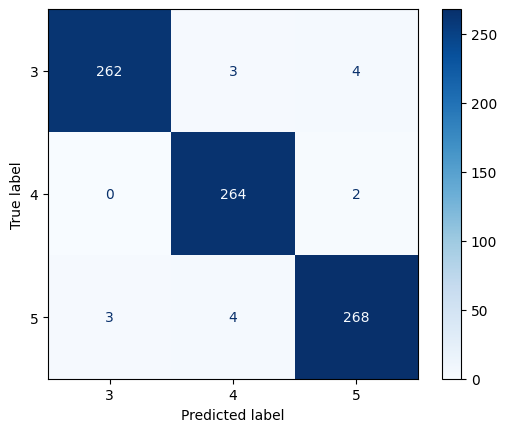

Exactitud: 0.98
Recall: 0.9803347842400866
Precisión: 0.9753604451609371
Puntuación F1: 0.9802780715271159

Reporte de Clasificación:
              precision    recall  f1-score   support

           3       0.98      0.97      0.98       269
           4       0.97      0.97      0.97       266
           5       0.97      0.98      0.98       275

    accuracy                           0.98       810
   macro avg       0.98      0.98      0.98       810
weighted avg       0.98      0.98      0.98       810



In [ ]:
from sklearn.svm import SVC

# Crear y entrenar el modelo SVM
svm = SVC(kernel='rbf', random_state=0)
svm.fit(X_train, y_train)
# Hacer predicciones y evaluar
y_pred_SVM = svm.predict(X_test)

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_SVM)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()



# Métricas de rendimiento sobre el conjunto de prueba
print('Exactitud: %.2f' % accuracy_score(y_test, y_pred_SVM))
print("Recall: {}".format(recall_score(y_test, y_pred_SVM, average='macro')))
print("Precisión: {}".format(precision_score(y_test, y_predRandom, average='macro')))
print("Puntuación F1: {}".format(f1_score(y_test, y_pred_SVM, average='macro')))

# Mostrar reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_predRandom))

##Evaluación sobre conjunto de entrenamiento

In [ ]:
# Hacer predicciones sobre el conjunto de entrenamiento
y_pred_trainsvm= svm.predict(X_train)


# Métricas de rendimiento sobre el conjunto de entrenamiento
print('Exactitud: %.2f' % accuracy_score(y_train, y_pred_trainsvm))
print("Recall: {}".format(recall_score(y_train, y_pred_trainsvm, average='macro')))
print("Precisión: {}".format(precision_score(y_train, y_pred_trainsvm, average='macro')))
print("Puntuación F1: {}".format(f1_score(y_train, y_pred_trainsvm, average='macro')))

Exactitud: 1.00
Recall: 0.9993746729461015
Precisión: 0.9994104620727997
Puntuación F1: 0.9993924095016947


##Analisis con Nuevos Hiperparametros

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejores hiperparámetros encontrados:
{'C': 10, 'kernel': 'rbf'}


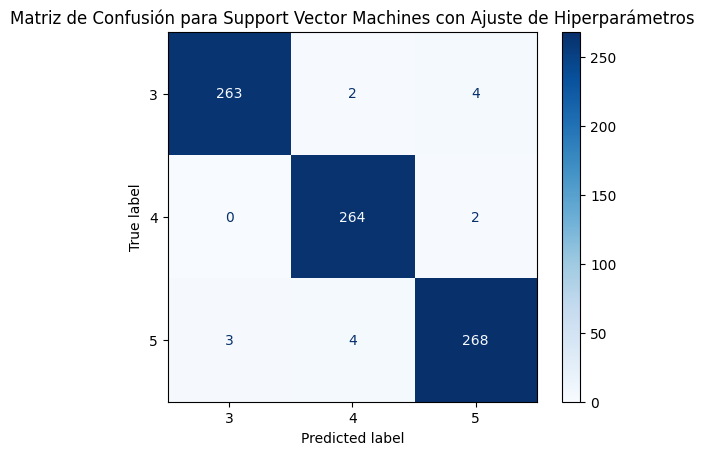

Exactitud: 0.98
Recall (macro): 0.9815739416130729
Precisión (macro): 0.9815339240233593
Puntuación F1 (macro): 0.9815242599456965


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Definir el modelo SVM
svm = SVC()

# Definir los hiperparámetros para ajustar
param_grid = {
    'C': [0.1, 1, 10, 100],  # Parámetro de regularización
    'kernel': ['linear', 'rbf'],  # Tipos de kernel

}

# Configurar GridSearchCV con 5-fold cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Entrenar el modelo utilizando GridSearchCV
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Utilizar el mejor modelo encontrado
best_svm = grid_search.best_estimator_

# Hacer predicciones en el conjunto de prueba
y_pred_svm = best_svm.predict(X_test)

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_svm)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión para Support Vector Machines con Ajuste de Hiperparámetros')
plt.show()


# Evaluar el rendimiento del mejor modelo encontrado
print('Exactitud: %.2f' % accuracy_score(y_test, y_pred_svm))
print("Recall (macro): {}".format(recall_score(y_test, y_pred_svm, average='macro')))
print("Precisión (macro): {}".format(precision_score(y_test, y_pred_svm, average='macro')))
print("Puntuación F1 (macro): {}".format(f1_score(y_test, y_pred_svm, average='macro')))


#Regresión Logística

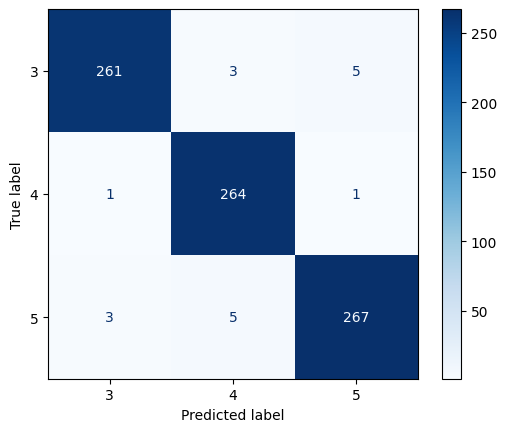

Exactitud: 0.9777777777777777
Precisión: 0.9778386245644848
Recall: 0.977883505654979
F1 Score: 0.9777977613457902


In [ ]:
#importar librerias
from sklearn.linear_model import LogisticRegression

# Entrenar el modelo
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Hacer predicciones y evaluar
y_predL = logreg.predict(X_test)

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_predL)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


# Evaluar el rendimiento del mejor modelo encontrado
accuracy = accuracy_score(y_test, y_predL)
precision = precision_score(y_test, y_predL, average='macro')
recall = recall_score(y_test, y_predL, average='macro')
f1 = f1_score(y_test, y_predL, average='macro')

print(f"Exactitud: {accuracy}")
print(f"Precisión: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

##Evaluación sobre conjunto de entrenamiento

In [ ]:
# Hacer predicciones sobre el conjunto de entrenamiento
y_pred_trainRL= logreg.predict(X_train)


# Métricas de rendimiento sobre el conjunto de entrenamiento
print('Exactitud: %.2f' % accuracy_score(y_train, y_pred_trainRL))
print("Recall: {}".format(recall_score(y_train, y_pred_trainRL, average='macro')))
print("Precisión: {}".format(precision_score(y_train, y_pred_trainRL, average='macro')))
print("Puntuación F1: {}".format(f1_score(y_train, y_pred_trainRL, average='macro')))

Exactitud: 1.00
Recall: 0.9955768589487076
Precisión: 0.9957819776010354
Puntuación F1: 0.9956760475813698


##Analisis con Nuevos Hiperparametros

Fitting 5 folds for each of 12 candidates, totalling 60 fits


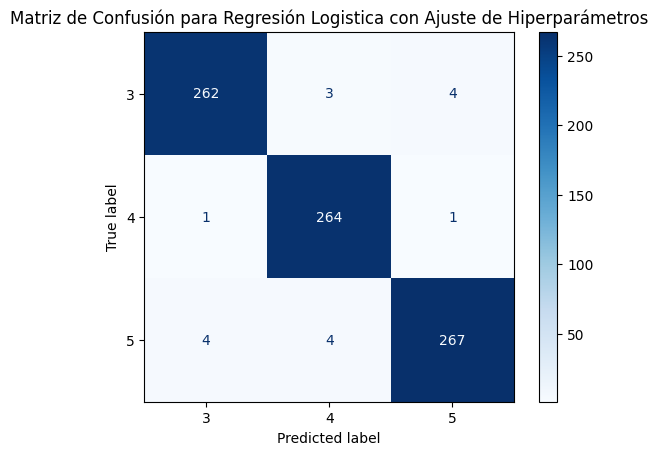

Exactitud: 0.9790123456790123
Precisión: 0.9790202656653135
Recall: 0.9791226630279652
F1 Score: 0.9790287224728339
Mejores hiperparámetros encontrados:
{'C': 10, 'solver': 'liblinear'}


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


logreg = LogisticRegression(max_iter=2000, class_weight='balanced')

#Definir los hiperparámetros para ajustar
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Parámetro de regularización con más valores
    'solver': ['lbfgs', 'liblinear']  # Algoritmos de optimización
}

# Configurar GridSearchCV con 5-fold cross-validation y optimización de F1
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=2)

# Entrenar el modelo utilizando GridSearchCV
grid_search.fit(X_train, y_train)

# Utilizar el mejor modelo encontrado
best_logreg = grid_search.best_estimator_

# Hacer predicciones con los datos escalados
y_predL = best_logreg.predict(X_test)

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_predL)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_logreg.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión para Regresión Logistica con Ajuste de Hiperparámetros')
plt.show()


# Evaluar el rendimiento del mejor modelo encontrado
accuracy = accuracy_score(y_test, y_predL)
precision = precision_score(y_test, y_predL, average='macro')
recall = recall_score(y_test, y_predL, average='macro')
f1 = f1_score(y_test, y_predL, average='macro')


print(f"Exactitud: {accuracy}")
print(f"Precisión: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)


##MultinomialNB

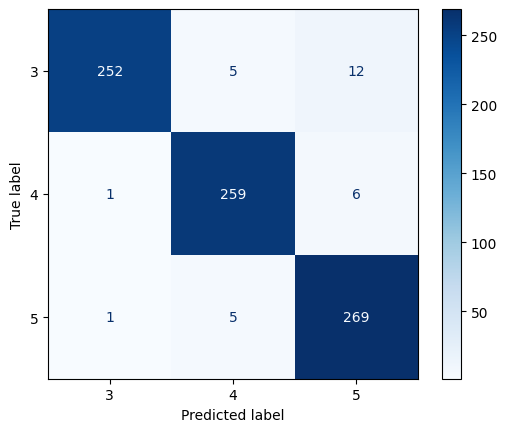

Exactitud: 0.96
Recall (macro): 0.962889667561943
Precisión (macro): 0.9640778310091781
Puntuación F1 (macro): 0.9630636002793252


In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_nb)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


print('Exactitud: %.2f' % accuracy_score(y_test, y_pred_nb))
print("Recall (macro): {}".format(recall_score(y_test, y_pred_nb, average='macro')))
print("Precisión (macro): {}".format(precision_score(y_test, y_pred_nb, average='macro')))
print("Puntuación F1 (macro): {}".format(f1_score(y_test, y_pred_nb, average='macro')))

##Hiperparámetros multinomialNB

Mejores hiperparámetros: {'alpha': 0.1}


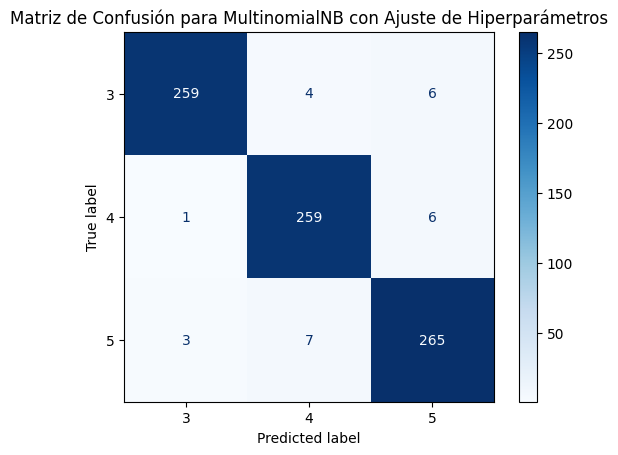

Exactitud: 0.97
Recall (macro): 0.9667152843243628
Precisión (macro): 0.9669096113816616
Puntuación F1 (macro): 0.966749016170103


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
param_grid = {'alpha': [0.05, 0.1, 0.5, 1.0, 2.0]}

nb = MultinomialNB()

grid_search = GridSearchCV(nb, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)


best_nb = grid_search.best_estimator_


y_pred_nb = best_nb.predict(X_test)


cm_nb = confusion_matrix(y_test, y_pred_nb)


disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=best_nb.classes_)
disp_nb.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión para MultinomialNB con Ajuste de Hiperparámetros')
plt.show()


print('Exactitud: %.2f' % accuracy_score(y_test, y_pred_nb))
print("Recall (macro): {}".format(recall_score(y_test, y_pred_nb, average='macro')))
print("Precisión (macro): {}".format(precision_score(y_test, y_pred_nb, average='macro')))
print("Puntuación F1 (macro): {}".format(f1_score(y_test, y_pred_nb, average='macro')))

#Predicciones

In [ ]:
# Cargar y preprocesar los datos de prueba
excel_path_prueba = '/content/TestODScat_345.xlsx'
datosPrueba = pd.read_excel(excel_path_prueba, engine='openpyxl')


# Guardar Archivo CSV temporal
csv_temp_path = '/content/TestODScat_temp.csv'
datosPrueba.to_csv(csv_temp_path, index=False)


# Aplicar ftfy para corregir la codificación
datosPrueba['Textos_espanol'] = datosPrueba['Textos_espanol'].apply(ftfy.fix_text)


# Guardar el DataFrame corregido en un archivo CSV
csv_path = '/content/TestODScat_corrected.csv'
datosPrueba.to_csv(csv_path, index=False, encoding='utf-8')



# Preprocesamiento igual que en los datos de entrenamiento
datosPrueba['words'] = datosPrueba['Textos_espanol'].apply(word_tokenize)
datosPrueba['words1'] = datosPrueba['words'].apply(preprocessing)
datosPrueba['words1'] = datosPrueba['words1'].apply(lemmatize_verbs)
datosPrueba['words1'] = datosPrueba['words1'].apply(lambda x: ' '.join(x))


from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

# Asegúrate de que el modelo se entrene con los mejores hiperparámetros
svm = SVC(C=10, kernel='rbf', random_state=0)

# Entrenar el modelo SVM con los datos de entrenamiento
svm.fit(X_train, y_train)  # Donde X_tf_idf_entrenamiento son tus datos entrenados y y_train las etiquetas

# Transformar los datos de prueba con el vectorizador entrenado
X_tf_idfPrueba = tf_idf_vectorizer.transform(datosPrueba['words1'])

# Realizar predicciones en los datos de prueba
y_pred_prueba = svm.predict(X_tf_idfPrueba)

# Agregar las predicciones
datosPrueba['sdg'] = y_pred_prueba

# Seleccionar solo las columnas deseadas
resultados = datosPrueba[['Textos_espanol', 'sdg']]

# Guardar el archivo con las predicciones
output_file_path = 'particion_prueba_estudiantes.csv'
resultados.to_csv(output_file_path, index=False)

